# **The Age of Recommender Systems**

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play.  Recommendation Systems are a type of **information filtering systems** as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user.  


They are used to predict the **rating** or **preference** that a user would give to an item. Almost every major tech company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay, and Facebook uses it to recommend pages to like and people to follow. 
Moreover,  companies like Netflix and Spotify  depend highly on the effectiveness of their recommendation engines for their business and sucees.

![](https://i.kinja-img.com/gawker-media/image/upload/s--e3_2HgIC--/c_scale,f_auto,fl_progressive,q_80,w_800/1259003599478673704.jpg)

In this kernel we'll be building a baseline Movie Recommendation System using [TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata). For novices like me this kernel will pretty much serve as a foundation in recommendation systems and will provide you with something to start with. 

**So let's go!**

There are basically three types of recommender systems:-

> *  **Demographic Filtering**- They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.



> *  **Content Based Filtering**- They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

> *  **Collaborative Filtering**- This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

Let's load the data now.

In [1]:
import pandas as pd 
import numpy as np 
#取四千个电影数据作为推荐
df1=pd.read_csv('IMDb movies.csv')[:4000]

D:\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df1.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:- 

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average -  average ratings the movie recieved.
* vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column


# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

## **Plot description based Recommender**

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the **overview** feature of our dataset. 
Let's take a look at the data. .. 

In [3]:
df1['description'].head(5)

0    The adventures of a female reporter in the 1890s.
1    True story of notorious Australian outlaw Ned ...
2    Two men of high rank are both wooing the beaut...
3    The fabled queen of Egypt's affair with Roman ...
4    Loosely adapted from Dante's Divine Comedy and...
Name: description, dtype: object

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it? 

In [4]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df1['description'] = df1['description'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df1['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4000, 12268)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
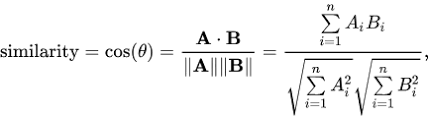

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [5]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [6]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df1.index, index=df1['title']).drop_duplicates()


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [7]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df1['title'].iloc[movie_indices]

In [8]:
get_recommendations('Madame DuBarry')

1718                         Voltaire
3411               La sposa di Boston
2270                     Le due città
1884                  Madame Du Barry
3044                   La marsigliese
260                  Le due orfanelle
3113            La fanciulla del ring
551     La ragazza con la cappelliera
1003                   Se io fossi re
3389              La regola del gioco
Name: title, dtype: object

In [9]:
get_recommendations('The Bargain')

792                     Rio Rita
2997          Nel cuore del Nord
1217                  Cortigiana
861              Captain Thunder
1972         Straight Is the Way
1106     La sposa nella tempesta
475             L'aquila azzurra
276               L'età di amare
2985            Give Me a Sailor
3665    One Night in the Tropics
Name: title, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

## **Credits, Genres and Keywords Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [10]:
# Parse the stringified features into their corresponding python objects
features = ['actors', 'director', 'writer', 'genre']

Next, we'll write functions that will help us to extract the required information from each feature.

In [11]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, str):
        split_list = x.split(',')
        if len(split_list) > 1:
            names = [i for i in split_list]
            # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
            if len(names) > 3:
                names = names[:3]
        elif len(split_list) == 1:
            names = [x]
    else:
        names = []
    return names

In [12]:
features = ['actors', 'director', 'writer', 'genre']
# features = ['actors']
for feature in features:
    df1[feature] = df1[feature].apply(get_list)

In [13]:
# Print the new features of the first 3 films
df1[['title', 'actors', 'director', 'writer', 'genre']].head(3)

,title,actors,director,writer,genre
0,Miss Jerry,"[Blanche Bayliss, William Courtenay, Chaunce...",[Alexander Black],[Alexander Black],[Romance]
1,The Story of the Kelly Gang,"[Elizabeth Tait, John Tait, Norman Campbell]",[Charles Tait],[Charles Tait],"[Biography, Crime, Drama]"
2,Den sorte drøm,"[Asta Nielsen, Valdemar Psilander, Gunnar He...",[Urban Gad],"[Urban Gad, Gebhard Schätzler-Perasini]",[Drama]


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [17]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [25]:
# Apply clean_data function to your features.
features = ['actors', 'director', 'writer', 'genre']

for feature in features:
    df1[feature] = df1[feature].apply(clean_data)

We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [26]:
df1[['title', 'actors', 'director', 'writer', 'genre']].head(3)

,title,actors,director,writer,genre
0,Miss Jerry,"[blanchebayliss, williamcourtenay, chaunceydepew]",[alexanderblack],[alexanderblack],[romance]
1,The Story of the Kelly Gang,"[elizabethtait, johntait, normancampbell]",[charlestait],[charlestait],"[biography, crime, drama]"
2,Den sorte drøm,"[astanielsen, valdemarpsilander, gunnarhelseng...",[urbangad],"[urbangad, gebhardschätzler-perasini]",[drama]


In [27]:
def create_soup(x):
    return ' '.join(x['writer']) + ' ' + ' '.join(x['actors']) + ' ' + ' '.join(x['director']) + ' ' + ' '.join(x['genre'])
df1['soup'] = df1.apply(create_soup, axis=1)

In [28]:
df1['soup'].head(3)

0    alexanderblack blanchebayliss williamcourtenay...
1    charlestait elizabethtait johntait normancampb...
2    urbangad gebhardschätzler-perasini astanielsen...
Name: soup, dtype: object

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [29]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df1['soup'])

In [30]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [31]:
# Reset index of our main DataFrame and construct reverse mapping as before
df1 = df1.reset_index()
indices = pd.Series(df1.index, index=df1['title'])

We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [33]:
get_recommendations('Madame DuBarry', cosine_sim2)

186                      Anna Bolena
116           Gli occhi della mummia
120                    Sangue gitano
223                          Sumurum
235                    Lo scoiattolo
316              Das Weib des Pharao
205                      Due sorelle
122               L'allegra prigione
727                       La valanga
142    La principessa delle ostriche
Name: title, dtype: object

In [34]:
get_recommendations('The Bargain', cosine_sim2)

54                   The Italian
44         The Wrath of the Gods
73                 Hell's Hinges
50                    The Coward
454                  Tumbleweeds
65                  Civilization
81       The Return of Draw Egan
181                 Wagon Tracks
225                The Toll Gate
739    Il bandito e la signorina
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add *production_company* . 
We can also increase the weight of the director , by adding the feature multiple times in the soup.